In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

from scripts.processing import clean_data, pre_process_data
from scripts.pipeline import create_preprocessing_pipeline

In [2]:
raw_train_data = pd.read_csv('data/train.csv') 

In [3]:
train_data = clean_data(raw_train_data)

In [4]:
train_data = pre_process_data(train_data)

In [5]:
# Passing through sklearn pipeline

num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.drop('Incurred')
ohe_cols = ['Notifier', 'Location_of_incident', 'Weather_conditions']

pipeline = create_preprocessing_pipeline(num_cols, ohe_cols)

X = train_data.drop(columns=['Incurred'])
y = train_data['Incurred']

X_preprocessed = pipeline.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [7]:
# Comparing different models

models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor()]

results = {}

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model.__class__.__name__] = root_mean_squared_error(y_test, y_pred)

results['Predicting Mean'] = root_mean_squared_error(y_test, [y_train.mean()]*len(y_test))
results['Predicting Median'] = root_mean_squared_error(y_test, [y_train.median()]*len(y_test))

pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values(by='RMSE')

,RMSE
Lasso,9391.920502
LinearRegression,9391.950169
Ridge,9392.022808
RandomForestRegressor,9542.128327
GradientBoostingRegressor,9616.060191
Predicting Mean,12158.738593
Predicting Median,13198.833487


In [9]:
param_grid = {'alpha': [0.1, 1, 10, 100]}

lasso = Lasso()
lasso_gs = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
lasso_gs.fit(X_train, y_train)
best_lasso = lasso_gs.best_estimator_
y_pred = best_lasso.predict(X_test)
#root_mean_squared_error(y_test, y_pred)

/Users/olivergibbons/opt/anaconda3/envs/claim_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.683e+09, tolerance: 4.991e+07
  model = cd_fast.enet_coordinate_descent(
/Users/olivergibbons/opt/anaconda3/envs/claim_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.168e+09, tolerance: 4.703e+07
  model = cd_fast.enet_coordinate_descent(
/Users/olivergibbons/opt/anaconda3/envs/claim_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

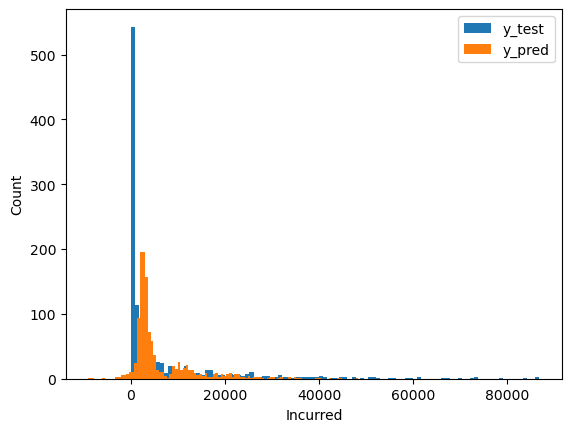

In [10]:
# Plot y_test histogram vs y pred histogram
plt.hist(y_test, bins=100, label='y_test')
plt.hist(y_pred, bins=100, label='y_pred')
plt.xlabel('Incurred')
plt.ylabel('Count')
plt.legend()

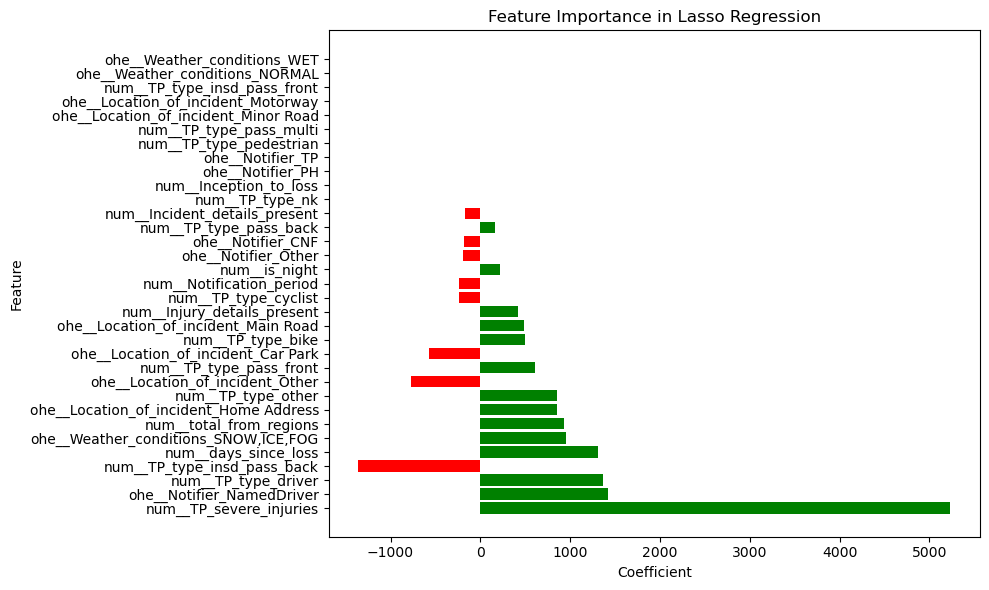

In [11]:
# Plot feature importance graph

feature_names = X_preprocessed.columns
coefficients = best_lasso.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=np.where(coef_df['Coefficient'] > 0, 'green', 'red'))

# Add labels and title
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Feature Importance in Lasso Regression')
plt.tight_layout()